In [1]:
ANDRE_REFERENCE_DATA = "../../test_data/system_tests/maxquant_yeast_interactome/1_Final_run_5x_1800_files/#1/evidence.txt.maxquant_evidence_andre_benchmark.aq_reformat.tsv"

In [2]:
#create a pandas dataframe with 100 rows and 10.000 columns
import pandas as pd
import numpy as np
import time

num_samples = 1000
num_proteins = 4000
df = pd.DataFrame(np.random.default_rng().normal(loc=100,scale= 30,size=(num_proteins, num_samples)), columns=list(range(num_samples)))
#create array of random integers of size num_samples
scaling_factors = np.random.default_rng().integers(low=10, high=1000, size=num_samples)

#add scaling factors to columns
for i in range(num_samples):
    df[i] = df[i] + scaling_factors[i]

mask = np.random.choice([0, 1], size=(num_proteins, num_samples), p=[0.8, 0.2])
#apply mask to df
df = df.mask(mask == 1)
display(df)

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,676.132672,893.135099,NaN,398.779088,NaN,832.470690,737.256145,847.002698,NaN,105.497443,...,844.561661,232.897111,956.422537,844.896582,697.029969,766.453012,623.903646,896.132137,975.396493,1015.151598
1,NaN,881.142796,201.050570,377.926019,NaN,840.119739,752.250506,898.019844,NaN,127.270112,...,907.095388,275.103811,853.724909,873.893582,677.474136,728.313916,NaN,903.714523,927.072015,1043.841157
2,NaN,860.515328,259.977392,387.362081,NaN,798.598122,798.852318,851.707288,243.941757,123.701315,...,865.920731,NaN,898.761439,NaN,NaN,759.100749,NaN,901.282025,952.895043,1095.128220
3,NaN,NaN,253.053540,460.788997,655.288545,804.260305,725.968432,869.406487,269.968221,128.090841,...,948.631750,270.426647,903.489928,894.587663,680.283808,694.298154,675.969755,911.916861,1004.685710,NaN
4,685.385189,NaN,255.198625,NaN,694.144607,914.119473,790.348161,868.523680,292.879421,120.030423,...,881.832432,233.781012,846.432926,872.146181,741.312177,722.218171,700.484503,929.706115,928.903629,1027.490329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,648.953771,852.715673,NaN,382.789036,667.762457,865.325717,784.121713,847.503881,270.004095,132.435798,...,NaN,255.583883,910.854067,901.971257,771.534801,785.668279,659.692448,942.820456,983.623403,1067.502757
3996,678.535936,NaN,238.505848,411.618971,634.048253,NaN,721.151501,858.048370,261.827389,107.276769,...,895.406585,240.299569,NaN,896.545720,733.706382,824.487272,631.451473,NaN,NaN,NaN
3997,609.042153,908.239513,304.236218,399.534902,678.343452,842.103251,765.962296,842.060397,283.361057,161.518235,...,871.224052,263.490609,886.213306,931.734296,727.281767,745.441871,632.425288,896.127927,973.849961,1034.988920
3998,661.310867,879.229636,257.233584,NaN,616.304072,895.828702,744.876569,NaN,313.429895,157.374713,...,875.764201,316.380974,923.647583,822.290389,744.746702,742.601892,NaN,885.990722,1006.613693,999.926919


In [3]:
import directlfq.normalization

class NormalizationManagerSamplesOnSelectedProteinsDirectInput(directlfq.normalization.NormalizationManagerSamples):
    def __init__(self, complete_dataframe, num_samples_quadratic, selected_protein_groups):
        complete_dataframe = complete_dataframe.T #the samples to shift are in each row, therefore the df needs to be transposed
        self._selected_protein_groups = selected_protein_groups
        super().__init__(complete_dataframe, num_samples_quadratic)
        self.normalization_function = self._normalization_function
        self._run_normalization()
        self.complete_dataframe = complete_dataframe.T

    def _adapt_selected_proteins_to_protein_groups(self):
        if self._selected_proteins_file is not None:
            print('Normalizing only selected proteins')
            selected_proteins = pd.read_csv(self._selected_proteins_file, header=None, sep='\t')[0].to_list()
            protein2proteingroup_mapping = self._get_protein2proteingroup_mapping()
            existing_selected_proteins = [protein for protein in selected_proteins if protein in protein2proteingroup_mapping.keys()]
            self._selected_protein_groups = [protein2proteingroup_mapping[protein] for protein in existing_selected_proteins]

    def _get_protein2proteingroup_mapping(self):
        protein_groups = self.complete_dataframe.columns.get_level_values(0).to_list()
        protein2proteingroup_mapping = {protein : protein_group for protein_group in protein_groups for protein in protein_group.split(';')}
        return protein2proteingroup_mapping

    def _normalization_function(self, ion_dataframe):
        if self._selected_protein_groups is not None:
            ion_dataframe_selected = ion_dataframe.loc[:,self._selected_protein_groups]
        else:
            ion_dataframe_selected = ion_dataframe
        sample2shift = directlfq.normalization.get_normfacts(directlfq.normalization.drop_nas_if_possible(ion_dataframe_selected).to_numpy())
        df_c_normed = pd.DataFrame(directlfq.normalization.apply_sampleshifts(ion_dataframe.to_numpy(), sample2shift), index = ion_dataframe.index, columns = ion_dataframe.columns)
        return df_c_normed

    def _create_reference_sample(self):
        quadratic_subset_dataframe = self.complete_dataframe.loc[self._quadratic_subset_rows, self._selected_protein_groups]
        self._merged_reference_sample = quadratic_subset_dataframe.median(axis=0)

    def _shift_remaining_dataframe_to_reference_sample(self):
        linear_subset_dataframe = self.complete_dataframe.loc[self._linear_subset_rows]
        linear_shifted_dataframe = directlfq.normalization.SampleShifterLinear(linear_subset_dataframe, self._merged_reference_sample, protein_subset = self._selected_protein_groups).ion_dataframe
        self.complete_dataframe.loc[ self._linear_subset_rows, :] = linear_shifted_dataframe

    

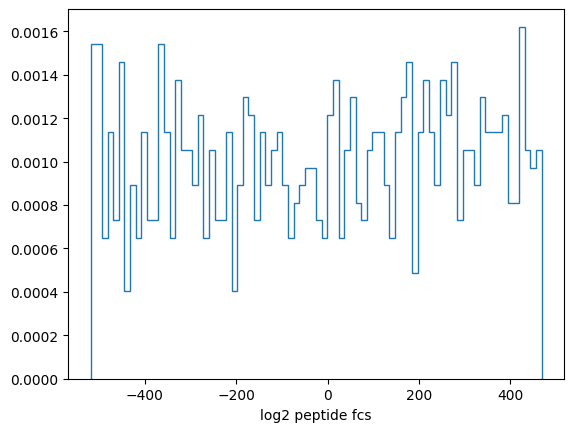

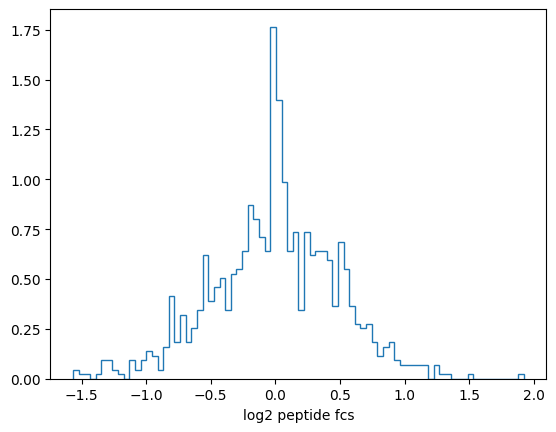

to few values for normalization without missing values. Including missing values


KeyError: '[3384, 3699, 3849, 1633, 3741, 1171, 3875, 1333, 3425, 2361, 2804, 3376, 2316, 3768, 2261, 1311, 2791, 1493, 2788, 3606, 1983, 2954, 2591, 3271, 2250, 1038, 3634, 3227, 2314, 1278, 2060, 3611, 2257, 2020, 3671, 3397, 1261, 2807, 2909, 1516, 3360, 3829, 1083, 3396, 2487, 2134, 1367, 3949, 2446, 1597, 2167, 2019, 1304, 1801, 1985, 1751, 3001, 1184, 1688, 3561, 1587, 1485, 1143, 2783, 2109, 2736, 3828, 2287, 3566, 2193, 3542, 2945, 3051, 3778, 3148, 2883, 1488, 3571, 2170] not in index'

In [4]:
import directlfq.normalization
import directlfq.visualizations as lfq_viz
import random

def visualize_normalization_steps(df_to_normalize):
    lfq_viz.plot_relative_to_median_fcs(df_to_normalize)
    input_df_normalized = directlfq.normalization.NormalizationManagerSamples(df_to_normalize.copy(), num_samples_quadratic=5).complete_dataframe
    lfq_viz.plot_relative_to_median_fcs(input_df_normalized)

    #randomly select 100 items from a list
    selected_protein_groups = random.sample(list(df_to_normalize.index), 100)
    input_df_normalized_selected_proteins = NormalizationManagerSamplesOnSelectedProteinsDirectInput(df_to_normalize.copy(), num_samples_quadratic=50, selected_protein_groups=selected_protein_groups).complete_dataframe
    lfq_viz.plot_relative_to_median_fcs(input_df_normalized_selected_proteins)
    display(input_df_normalized_selected_proteins)


visualize_normalization_steps(df)

In [5]:
import pandas as pd
df_to_normalize = pd.read_csv(ANDRE_REFERENCE_DATA, sep='\t')

/var/folders/wb/j08kzzbd2hd8838tn3ll0jfm0000gn/T/ipykernel_33647/2796637333.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_to_normalize = pd.read_csv(ANDRE_REFERENCE_DATA, sep='\t')


In [6]:
display(df_to_normalize)

,protein,ion,20190621_TIMS3_Evo4_AnMi_SA_Yeast-Interactome_0001_P01A01_YLR106C___01,20190621_TIMS3_Evo4_AnMi_SA_Yeast-Interactome_0001_P01A01_YLR106C___02,20190621_TIMS3_Evo4_AnMi_SA_Yeast-Interactome_0002_P01B01_YKR054C___01,20190621_TIMS3_Evo4_AnMi_SA_Yeast-Interactome_0002_P01B01_YKR054C___02,20190621_TIMS3_Evo4_AnMi_SA_Yeast-Interactome_0003_P01C01_YDR457W___01,20190621_TIMS3_Evo4_AnMi_SA_Yeast-Interactome_0003_P01C01_YDR457W___02,20190621_TIMS3_Evo4_AnMi_SA_Yeast-Interactome_0004_P01D01_YDR150W___01,20190621_TIMS3_Evo4_AnMi_SA_Yeast-Interactome_0004_P01D01_YDR150W___02,...,Library_15,Library_16,Library_17,Library_18,Library_19,Library_20,Library_21,Library_22,Library_23,Library_24
0,0,LRTDETLRLTGNPELSSLDEVLAKUnmodified4,2.183500e+04,0.000000e+00,1.083500e+04,0.000000e+00,1.119100e+04,0.0,9.431800e+03,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,EREWVAGMSSAGDRSSYEDSVKOxidation (M)2,2.157900e+05,1.285600e+06,2.814000e+06,9.893700e+05,0.000000e+00,824170.0,0.000000e+00,1.072000e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,EREWVAGMSSAGDRSSYEDSVKOxidation (M)3,4.839570e+06,5.484228e+06,7.682778e+06,5.322510e+06,6.022000e+06,7496200.0,9.654700e+06,6.810833e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,EREWVAGMSSAGDRSSYEDSVKOxidation (M)4,5.593080e+05,1.464768e+06,1.263365e+06,1.771694e+06,1.936322e+06,2626133.0,7.986569e+05,2.200028e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,EREWVAGMSSAGDRSSYEDSVKUnmodified2,5.464600e+06,7.028600e+06,3.913750e+06,9.563200e+06,7.482400e+06,6507950.0,5.469000e+06,4.518841e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61198,999,DLTDDINLVKUnmodified2,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,...,537690.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61199,999,EMDVLMEPVRNVFGSTK2 Oxidation (M)2,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,76754.0,0.0,0.0,84014.0,0.0
61200,999,MLSYPITIGSLLHKOxidation (M)2,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,...,203830.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61201,999,MLSYPITIGSLLHKOxidation (M)3,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,...,306940.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
df_to_normalize = df_to_normalize.drop(columns=["protein", "ion"])
df_to_normalize = df_to_normalize.replace(0, np.nan)

In [8]:
df_to_normalize = np.log2(df_to_normalize)

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

def visualize_impact_of_quadratic_sample_size_on_normalization(df_to_normalize):
    df = pd.DataFrame()
    all_cvs = []
    sample_sizes = []
    sample_list = [5, 10, 25, 50, 100, 200, 500, 1000]
    for num_samples_quadratic in sample_list:
        cvs_sample_size = get_cvs_for_given_quadratic_sample_size(df_to_normalize, num_samples_quadratic)
        all_cvs.extend(cvs_sample_size)
        sample_sizes.extend([num_samples_quadratic] * len(cvs_sample_size))
    df_boxplot = pd.DataFrame({'CV': all_cvs, 'sample size': sample_sizes})
    return df_boxplot
    
    
    

def get_cvs_for_given_quadratic_sample_size(df_to_normalize, num_samples_quadratic):
    input_df_normalized = directlfq.normalization.NormalizationManagerSamples(df_to_normalize.copy(), num_samples_quadratic=num_samples_quadratic).complete_dataframe
    cvs = input_df_normalized.apply(cv_function, axis='columns')
    return cvs

def cv_function(x):
    x = x.to_numpy()
    if sum(~np.isnan(x)) <2:
        return np.nan
    return np.nanstd(2**x, ddof=1,) / np.nanmean(2**x)


df_boxplot = visualize_impact_of_quadratic_sample_size_on_normalization(df_to_normalize=df_to_normalize)


to few values for normalization without missing values. Including missing values


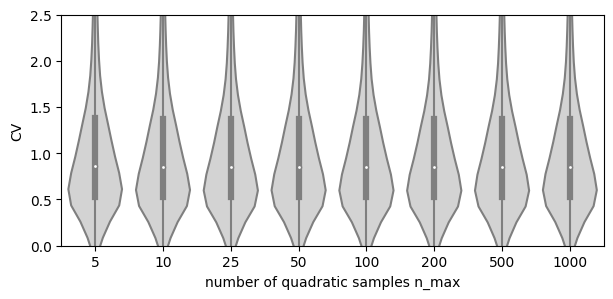

In [16]:
fig, ax = plt.subplots(figsize=(7, 3))
sns.violinplot(x="sample size", y="CV", data=df_boxplot, ax=ax, color='lightgrey')
ax.set_xlabel('number of quadratic samples n_max')

fig.savefig('quadratic_sample_size.png', dpi=300, bbox_inches='tight')
fig.savefig('quadratic_sample_size.pdf', dpi=300, bbox_inches='tight')

ax.set_ylim(0, 2.5)

fig.savefig('quadratic_sample_size_zoomed.png', dpi=300, bbox_inches='tight')
fig.savefig('quadratic_sample_size_zoomed.pdf', dpi=300, bbox_inches='tight')

